In [ ]:
import hist
import boost_histogram as bh
import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt
from utilities import boostHistHelpers as hh
from wremnants import histselections as sel
from wremnants import datasets2016
from wremnants import plot_tools
import wremnants
import h5py
import uproot
import narf
hep.style.use(hep.style.ROOT)

sh: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
sh: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
sh: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
sh: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
sh: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


Welcome to JupyROOT 6.28/02


In [ ]:
with h5py.File("../mw_with_mu_eta_pt_scetlib_dyturboCorr_maxFiles1.hdf5", "r") as f:
    result = narf.ioutils.pickle_load_h5py(f["results"])
    #print(result['WminustaunuPostVFP']['event_count'])
    print(result['ZmumuPostVFP']['output'].keys())

In [118]:
f = h5py.File("../mw_with_mu_eta_pt_scetlib_dyturboCorr.hdf5", "r")
results = narf.ioutils.pickle_load_h5py(f["results"])

proc = 'WplusmunuPostVFP'
proc_name_latex = {
    'WplusmunuPostVFP': r'$W^+ \rightarrow \mu^+ \nu$',
    'WminusmunuPostVFP': r'$W^- \rightarrow \mu^- \nu$',
    'ZmumuPostVFP': r'$Z \rightarrow \mu^+ \mu^-$'
}
print(results[proc]['output'].keys())

nuisances = [
    'muonScaleSyst_responseWeights',
#    'Z_non_closure_parametrized',
    'Z_non_closure_parametrized_A',
    'Z_non_closure_parametrized_M',
#    'Z_non_closure_binned'
]
hists = {}
hists['nominal'] = results[proc]['output']['nominal'].get()
hists['nominal_gensmear'] = results[proc]['output']['nominal_gen_smeared'].get()
for nuisance in nuisances:
    hists[nuisance + '_gensmear'] = results[proc]['output'][nuisance + '_gensmear'].get()
    hists['nominal_' + nuisance] = results[proc]['output']['nominal_' + nuisance].get()

action = lambda x: x.project('pt')

fig = plot_tools.makePlotWithRatioToRef(
    [
        action(hists['nominal_gensmear']),
        action(hists['muonScaleSyst_responseWeights_gensmear'][...,141,0]),
        action(hists['muonScaleSyst_responseWeights_gensmear'][...,141,1])
    ],
    labels = [
        'nominal', 
        'smearing weights DOWN',
        'smearing weights UP'
    ],
    colors = ['black', 'green', 'green'],
    rrange = [0.99995, 1.00005],
    nlegcols = 1,
    rlabel = 'var/nominal',
    xlabel = r'GEN smeared $p_T^{\mu}$',
    plot_title = proc_name_latex[proc],
    grid = True
)
#hists['nominal_Z_non_closure_parametrized'].values()

dict_keys(['mTStudyForFakes', 'mtIsoJetCharge', 'MET', 'transverseMass', 'nominal_qcdJetPt30', 'nominal', 'nominal_weight', 'nominal_recoilUnc_source_para', 'nominal_recoilUnc_source_perp', 'nominal_recoilUnc_target_para', 'nominal_recoilUnc_target_para_bkg', 'nominal_recoilUnc_target_perp', 'nominal_recoilUnc_target_perp_bkg', 'nominal_uncorr', 'weight_uncorr', 'nominal_scetlib_dyturboCorr', 'nominal_scetlib_dyturboOmega', 'nominal_gen', 'nominal_gen_smeared', 'nominal_effStatTnP_sf_reco', 'nominal_effStatTnP_sf_tracking', 'nominal_effStatTnP_sf_idip', 'nominal_effStatTnP_sf_trigger', 'nominal_effStatTnP_sf_iso', 'nominal_effSystTnP', 'nominal_muonL1PrefireStat', 'nominal_muonL1PrefireSyst', 'nominal_ecalL1Prefire', 'nominal_luminosity', 'nominal_pdfMSHT20', 'nominal_pdfMSHT20alphaS002', 'nominal_qcdScale', 'nominal_qcdScaleByHelicity', 'nominal_massWeight', 'nominal_muonScaleSyst', 'nominal_muonScaleSyst_gen_smear', 'nominal_muonScaleSystPerSeDown', 'nominal_muonScaleSystPerSeUp', 'm

KeyError: 'nominal_muonScaleSyst_responseWeights_spline'

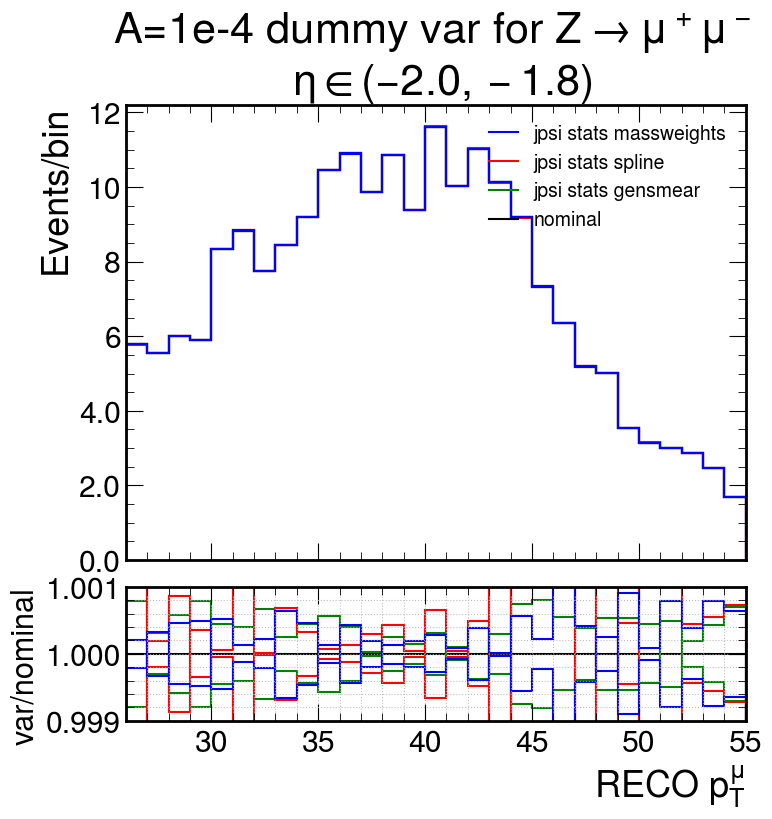

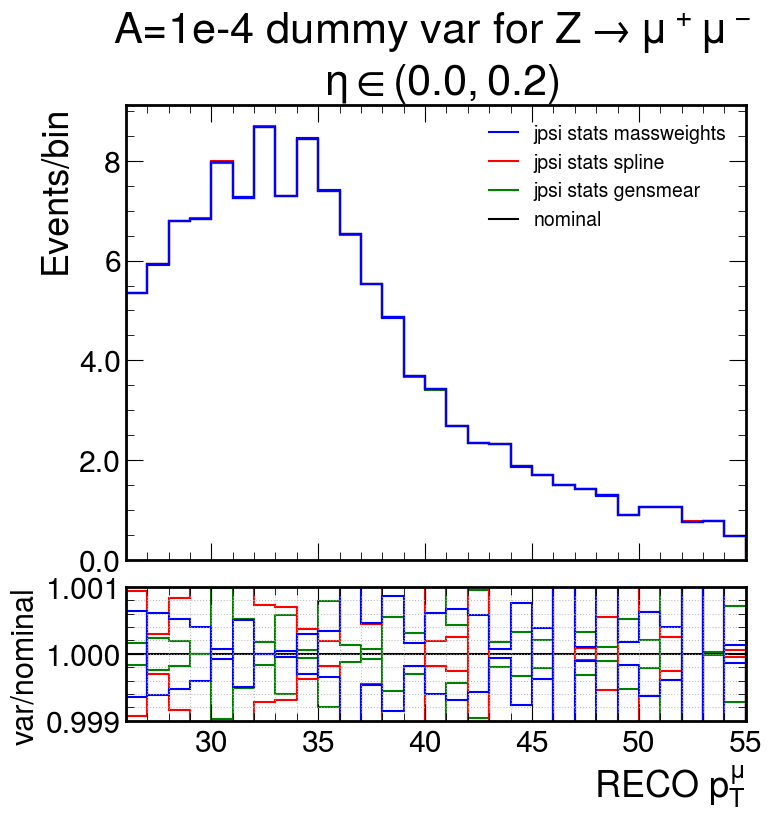

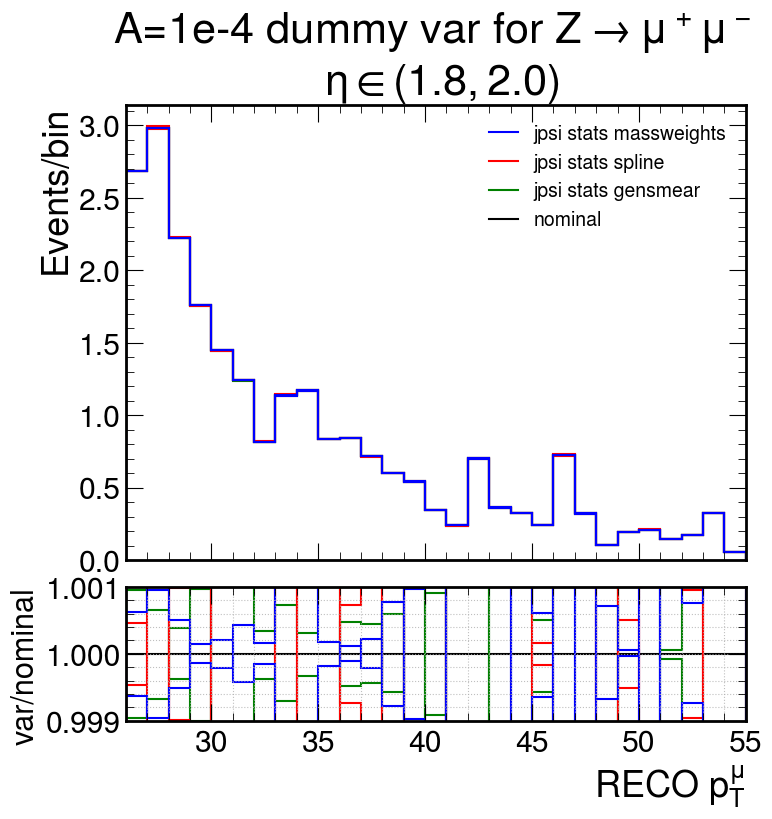

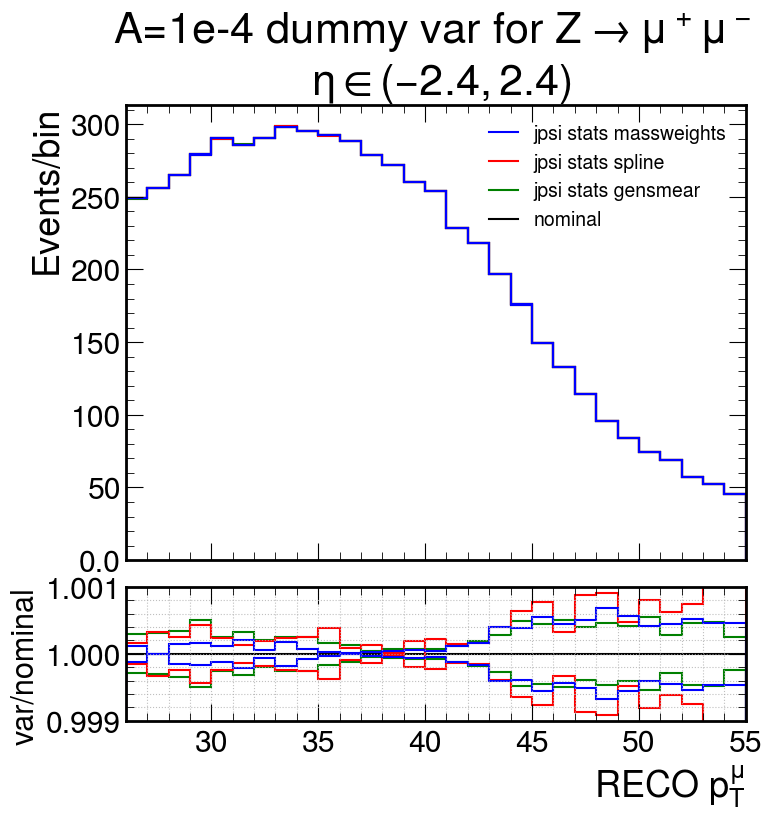

In [47]:
############################################################
# comparison of muon scale var derived by different methods
############################################################

import hist
import boost_histogram as bh
import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt
from utilities import boostHistHelpers as hh
from wremnants import histselections as sel
from wremnants import datasets2016
from wremnants import plot_tools
import wremnants
import h5py
import uproot
import narf
import os
hep.style.use(hep.style.ROOT)

proc = 'ZmumuPostVFP'
proc_name_latex = {
    'WplusmunuPostVFP': r'$W^+ \rightarrow \mu^+ \nu$',
    'WminusmunuPostVFP': r'$W^- \rightarrow \mu^- \nu$',
    'ZmumuPostVFP': r'$Z \rightarrow \mu^+ \mu^-$'
}
dummyVar = '_dummyVar'
dummyVar_title = 'A=1e-4 dummy var'
action = lambda x: x.project('pt')
unc = {}
etas = {
    '(-2.0, -1.8)':3,
    '(0.0, 0.2)':12,
    '(1.8, 2.0)':21,
    '(-2.4, 2.4)':24
}

def save_pdf_and_png_toEos(outdir, plot_basename, eosdir, fig=None):
    plot_tools.save_pdf_and_png(out_dir, plot_basename, fig)
    os.system(f'xrdcp -f {out_dir}/{plot_basename}.pdf root://eosuser.cern.ch/{eos_dir}')
    os.system(f'xrdcp -f {out_dir}/{plot_basename}.png root://eosuser.cern.ch/{eos_dir}')

for etabin in etas.keys():
    sel_nom = {'eta':etas[etabin], 'charge':1j, 'passIso':1j, 'passMT':1j}
    sel_dn =  {'eta':etas[etabin], 'charge':1j, 'passIso':1j, 'passMT':1j, 'unc':0, 'downUpVar':0}
    sel_up =  {'eta':etas[etabin], 'charge':1j, 'passIso':1j, 'passMT':1j, 'unc':0, 'downUpVar':1}
    sel_dn_m =  {'eta':etas[etabin], 'charge':1j, 'passIso':1j, 'passMT':1j, 'downUpVar':0}
    sel_up_m =  {'eta':etas[etabin], 'charge':1j, 'passIso':1j, 'passMT':1j, 'downUpVar':1}
    if etabin == '(-2.4, 2.4)':
        sel_nom.pop('eta')
        sel_dn.pop('eta')
        sel_up.pop('eta')
        sel_dn_m.pop('eta')
        sel_up_m.pop('eta')
    with h5py.File(f"../hdf5Files/splines/mw_with_mu_eta_pt_scetlib_dyturboCorr_validation{dummyVar}_coarseQuantile_maxFiles31.hdf5", "r") as f:
        results = narf.ioutils.pickle_load_h5py(f["results"])
        nom = action(results[proc]['output']['nominal'].get()[sel_nom])
        unc['spline_dn'] = action(results[proc]['output']['muonScaleSyst_responseWeights_spline'].get()[sel_dn])
        unc['spline_up'] = action(results[proc]['output']['muonScaleSyst_responseWeights_spline'].get()[sel_up])
        unc['gensmear_dn'] = action(results[proc]['output']['nominal_muonScaleSyst_responseWeights'].get()[sel_dn])
        unc['gensmear_up'] = action(results[proc]['output']['nominal_muonScaleSyst_responseWeights'].get()[sel_up])
        unc['massweights_dn'] = action(results[proc]['output']['muonScaleSyst_responseWeights_massweights'].get()[sel_dn])
        unc['massweights_up'] = action(results[proc]['output']['muonScaleSyst_responseWeights_massweights'].get()[sel_up])
        unc['manual_dn'] = action(results[proc]['output']['muonScaleSyst_manualShift'].get()[sel_dn_m])
        unc['manual_up'] = action(results[proc]['output']['muonScaleSyst_manualShift'].get()[sel_up_m])

    fig = plot_tools.makePlotWithRatioToRef(
        [
            nom,
            unc['gensmear_dn'],
            unc['gensmear_up'],
            unc['spline_dn'],
            unc['spline_up'],
            unc['massweights_dn'],
            unc['massweights_up']
            #unc['manual_dn'],
            #unc['manual_up']
        ],
        labels = [
            'nominal',
            'jpsi stats gensmear',
            '_jpsi stats gensmear',
            'jpsi stats spline',
            '_jpsi stats spline',
            'jpsi stats massweights',
            '_jpsi stats massweights'
            #'jpsi stats manual',
            #'_jpsi stats manual'
        ],
        colors = ['black', 'green', 'green', 'red', 'red', 'blue', 'blue'], #'orange', 'orange'], #'orange', 'orange'],
        rrange = [0.999, 1.001],
        nlegcols = 1,
        rlabel = 'var/nominal',
        xlabel = r'RECO $p_T^{\mu}$',
        plot_title = f'{dummyVar_title} for {proc_name_latex[proc]} \n $\eta \in {etabin}$',
        grid = True
    )

    out_dir = '/home/submit/tyjyang/analysis/wmass/WRemnants/plots'
    plot_basename = f'muonScaleComparison{dummyVar}_eta{etas[etabin]}'
    eos_dir = '/eos/user/t/tyjyang/www/plots/wmass/muon-calibration/jpsi-stats-unc/spline'
    #save_pdf_and_png_toEos(out_dir, plot_basename, eos_dir, fig=None)
    

<bound method BaseHist.sum of Hist(Regular(1000, 0.99, 1.01, name='weights'), storage=Double()) # Sum: 76021869.21261632 (76027175.52879141 with flow)>
<bound method BaseHist.sum of Hist(Regular(1000, 0.99, 1.01, name='weights'), storage=Double()) # Sum: 66786434.78772036 (76027175.52879171 with flow)>


sh: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
sh: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


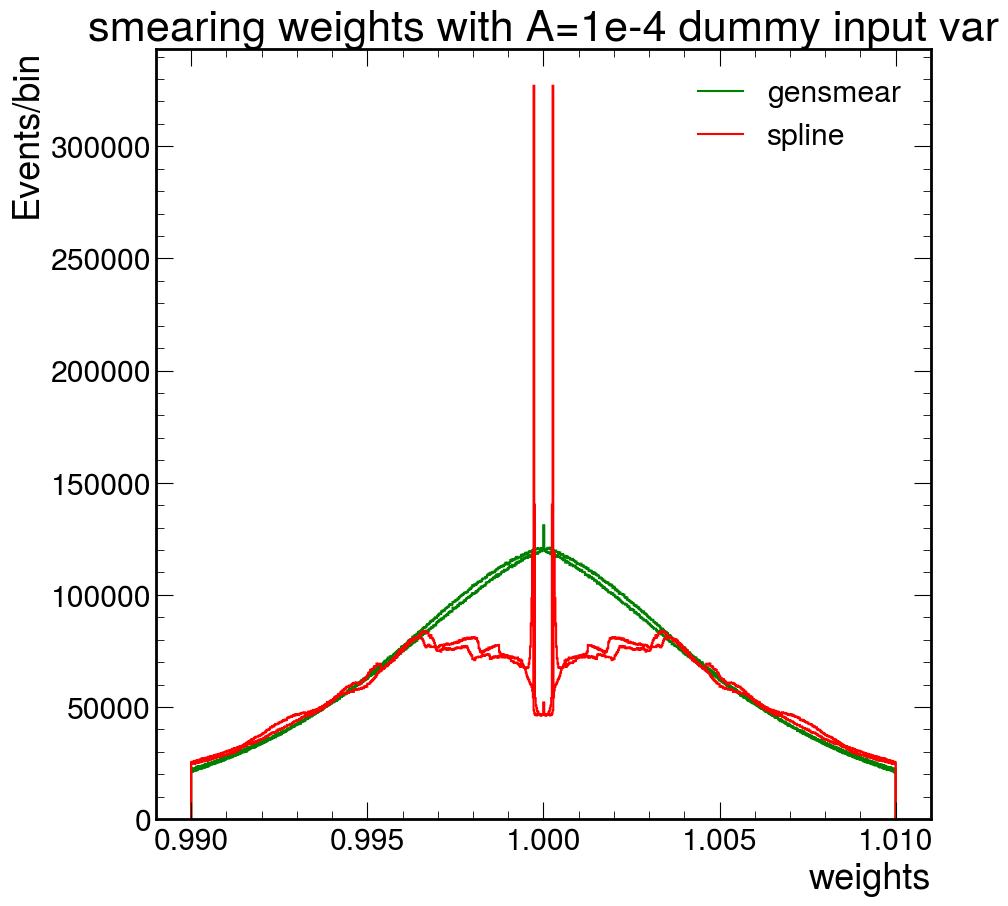

In [43]:
#############################################################################
# comparison of the smearing weights themselves derived via different methods
#############################################################################

import hist
import boost_histogram as bh
import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt
from utilities import boostHistHelpers as hh
from wremnants import histselections as sel
from wremnants import datasets2016
from wremnants import plot_tools
import wremnants
import h5py
import uproot
import narf
import os
hep.style.use(hep.style.ROOT)

def save_pdf_and_png_toEos(outdir, plot_basename, eosdir, fig=None):
    plot_tools.save_pdf_and_png(out_dir, plot_basename, fig)
    os.system(f'xrdcp -f {out_dir}/{plot_basename}.pdf root://eosuser.cern.ch/{eos_dir}')
    os.system(f'xrdcp -f {out_dir}/{plot_basename}.png root://eosuser.cern.ch/{eos_dir}')
    
dummyVar = '_dummyVar'
dummyVar_title = 'A=1e-4 dummy input var'
action = lambda x: x.project('weights')
sel_nom = {'passIso': 1j, 'passMT': 1j}


with h5py.File(f"../hdf5Files/splines/mw_with_mu_eta_pt_scetlib_dyturboCorr_validation{dummyVar}_coarseQuantile.hdf5", "r") as f:
    results = narf.ioutils.pickle_load_h5py(f["results"])
    proc = 'WplusmunuPostVFP'
    fig, ax = plt.subplots()
    hep.histplot(
        action(results[proc]['output']['weights_gensmear_dn'].get()[sel_nom]), 
        label = 'gensmear', ax = ax, yerr = False, color = 'green'
    )
    hep.histplot(
        action(results[proc]['output']['weights_gensmear_up'].get()[sel_nom]),
        label = '_gensmear', ax = ax, yerr = False, color = 'green'
    )
    hep.histplot(
        action(results[proc]['output']['weights_spline_dn'].get()[sel_nom]),
        label = 'spline', ax = ax, yerr = False, color = 'red'
    )
    hep.histplot(
        action(results[proc]['output']['weights_spline_up'].get()[sel_nom]),
        label = '_spline', ax = ax, yerr = False, color = 'red'
    )
    #hep.histplot(
    #    action(results[proc]['output']['weights_massweights_dn'].get()[sel_nom]),
    #    label = 'massweights', ax = ax, yerr = False, color = 'blue'
    #)
    #hep.histplot(
    #    action(results[proc]['output']['weights_massweights_up'].get()[sel_nom]),
    #    label = '_massweights', ax = ax, yerr = False, color = 'blue'
    #)
    ax.legend()
    ax.set_title(f'smearing weights with {dummyVar_title}')
    ax.set_ylabel('Events/bin')
    #ax.set_xlim(0.5,2)
    out_dir = '/home/submit/tyjyang/analysis/wmass/WRemnants/plots'
    plot_basename = f'weightsComparison{dummyVar}_coarseQuantile'
    eos_dir = '/eos/user/t/tyjyang/www/plots/wmass/muon-calibration/jpsi-stats-unc/spline'
    save_pdf_and_png_toEos(out_dir, plot_basename, eos_dir, fig)


    print(action(results[proc]['output']['weights_massweights_dn'].get()[sel_nom]).sum)
    print(action(results[proc]['output']['weights_gensmear_dn'].get()[sel_nom]).sum)



In [ ]:
hep.hist2dplot(cov)

In [14]:
import uproot
import hist
import numpy as np
from wremnants import muon_validation

def get_covmat(filepath, n_scale_params, n_tot_params, n_eta_bins):
    f = uproot.open(filepath)
    cov = f['covariance_matrix'].to_hist()
    cov_scale_params = muon_validation.get_jpsi_scale_param_cov_mat(
        cov, n_scale_params, n_tot_params, n_eta_bins
    )
    return cov_scale_params

def make_hist_covmat_diag(cov_scale_params):
    w,v = np.linalg.eigh(cov_scale_params)
    var_mat = np.sqrt(w) * v
    axis_eta = hist.axis.Regular(n_eta_bins, -2.4, 2.4, name = 'eta')
    axis_scale_params = hist.axis.Regular(n_scale_params, 0, 1, name = 'scale_params')
    axis_scale_params_unc = hist.axis.Regular(
        n_eta_bins * n_scale_params, 0, n_eta_bins * n_scale_params,
        underflow = False, overflow = False,  name = 'unc'
    )
    hist_scale_params_unc = hist.Hist(axis_eta, axis_scale_params, axis_scale_params_unc)
    for i in range(n_eta_bins):
        lb, ub = i * n_scale_params, (i + 1) * n_scale_params
        hist_scale_params_unc.view()[i,...] = var_mat[lb:ub][:]
    return hist_scale_params_unc

def get_variance_on_AeM(filepath, n_scale_params, n_tot_params, n_eta_bins):
    covmat = get_covmat(filepath, n_scale_params, n_tot_params, n_eta_bins)
    A_var = np.empty(n_eta_bins)
    e_var = np.empty(n_eta_bins)
    M_var = np.empty(n_eta_bins)
    for i in range(n_eta_bins):
        A_var[i] = (covmat.diagonal()[n_scale_params*i])
        e_var[i] = (covmat.diagonal()[n_scale_params*i+1])
        M_var[i] = (covmat.diagonal()[n_scale_params*i+2])
    return A_var, e_var, M_var

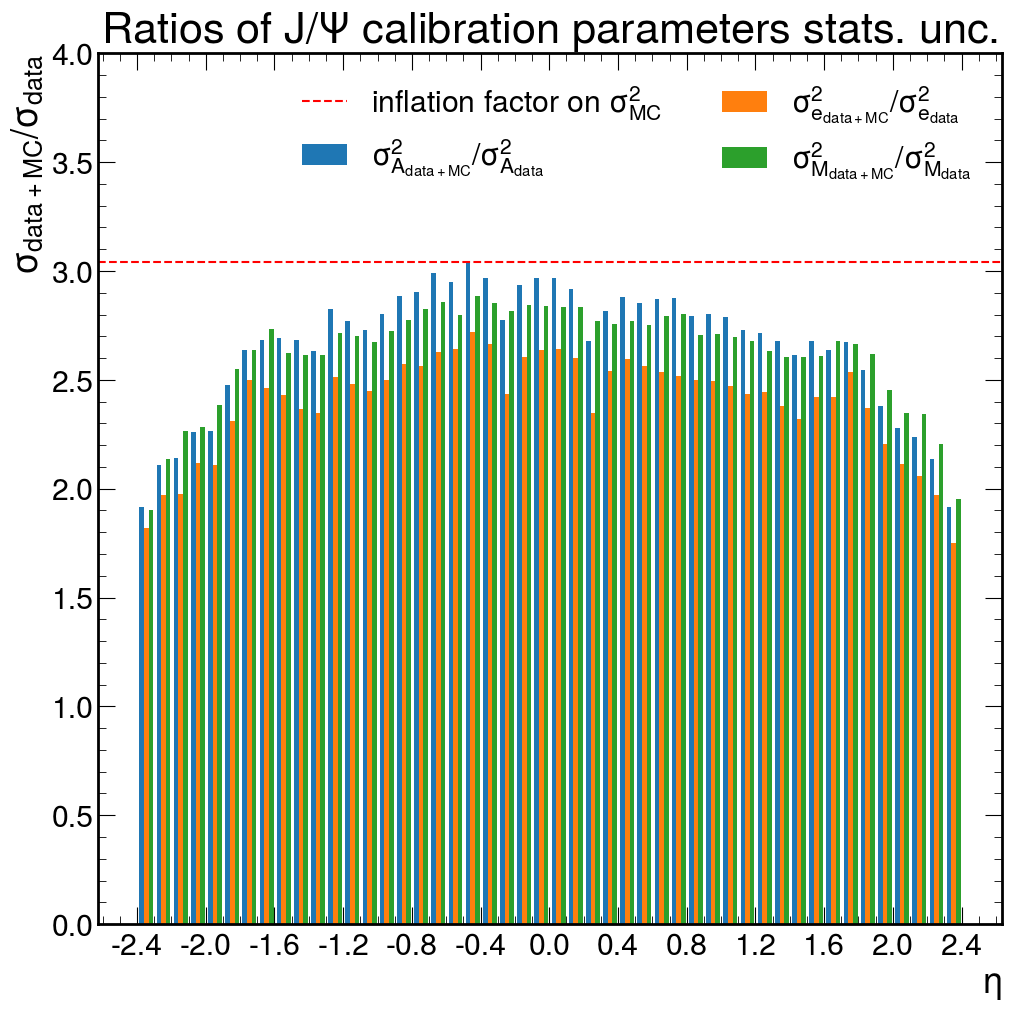

In [64]:
n_scale_params = 3
n_tot_params = 4
n_eta_bins = 48
filepath_old = '../wremnants/data/calibration/calibrationJDATA_rewtgr_3dmap_LBL_v721.root'
filepath_new = '../wremnants/data/calibration/calibrationJDATA_rewtgr_3dmap_LBL_MCstat.root'
A_var_old, e_var_old, M_var_old = get_variance_on_AeM(filepath_old, n_scale_params, n_tot_params, n_eta_bins)
A_var_new, e_var_new, M_var_new = get_variance_on_AeM(filepath_new, n_scale_params, n_tot_params, n_eta_bins)
ratio_A_var = A_var_new / A_var_old
ratio_e_var = e_var_new / e_var_old
ratio_M_var = M_var_new / M_var_old

from wremnants import plot_tools
eta = np.arange(-2.4, 2.4, 0.1)
ratio_vars = {
    r'$\sigma^2_{A_{{data+MC}}}/\sigma^2_{A_{{data}}}$': ratio_A_var,
    r'$\sigma^2_{e_{{data+MC}}}/\sigma^2_{e_{{data}}}$': ratio_e_var,
    r'$\sigma^2_{M_{{data+MC}}}/\sigma^2_{M_{{data}}}$': ratio_M_var
}
width = 0.027  # the width of the bars
multiplier = 1

fig, ax = plt.subplots(layout='constrained')

for group, var in ratio_vars.items():
    offset = width * multiplier
    rects = ax.bar(eta + offset, var, width, label=group)
    #ax.bar_label(rects, padding=3)
    multiplier += 1
ax.axhline(y=3.04, color='r', linestyle='--', label=r'inflation factor on $\sigma^2_{MC}$')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'$\sigma_{data+MC}/\sigma_{data}$')
ax.set_xlabel(r'$\eta$')
ax.set_title(r'Ratios of $J/\Psi$ calibration parameters stats. unc.')
ticks = np.arange(-2.4, 2.8, 0.4)
ax.set_xticks(ticks)
ax.legend(loc='upper right', ncols = 2)
ax.set_ylim(0, 4)

plot_tools.save_pdf_and_png(
    '/eos/user/t/tyjyang/www/plots/wmass/muon-calibration/jpsi_stats_unc',
    'jpsi_stats_unc_boostrapping_vs_inflation'
)
plt.show()

In [19]:
f = uproot.open(filepath_new)
f['covariance_matrix'].values()

array([[ 1.40495600e-07,  9.31065973e-07,  1.59168866e-11, ...,
        -3.52460068e-15, -1.89146873e-15,  3.11280492e-18],
       [ 9.31065973e-07,  6.93743347e-06,  3.23525333e-10, ...,
        -2.81941932e-14, -1.49490785e-14,  2.46775250e-17],
       [ 1.59168866e-11,  3.23525333e-10,  2.16355561e-10, ...,
         8.88000151e-15,  4.61446835e-15, -7.56582504e-18],
       ...,
       [-3.52460068e-15, -2.81941932e-14,  8.88000151e-15, ...,
         6.90144899e-06, -2.74290293e-10,  8.72852644e-11],
       [-1.89146873e-15, -1.49490785e-14,  4.61446835e-15, ...,
        -2.74290293e-10,  2.14643356e-10, -1.05847410e-12],
       [ 3.11280492e-18,  2.46775250e-17, -7.56582504e-18, ...,
         8.72852644e-11, -1.05847410e-12,  8.10476009e-11]])